In [1]:
import random
import numpy as np
import scipy.io
from pyDOE import lhs

import torch
from torch import nn, optim, autograd

import torch.nn.init as init
from torch.nn import functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils_training_base import *

#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [2]:
N_train = 10000
N_bound = 200

# x,t
la = np.array([1, 1])
lb = np.array([-1, 0])

traindata = lb + (la - lb) * lhs(2, N_train)
x_inside = traindata[:, 0:1]
t_inside = traindata[:, 1:2]

x_inside = numpy_to_tensor(x_inside,
                           var_name="x_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

t_inside = numpy_to_tensor(t_inside,
                           var_name="t_inside",
                           value_range_dim=True,
                           to_torch=True,
                           to_cuda=True,
                           requires_grad=True)

x_inside: Column 0: range from -0.9999616961099242 to 0.9999978533771987
t_inside: Column 0: range from 6.22108771039832e-05 to 0.9999811550774386


In [3]:
from scipy.io import loadmat

data = loadmat('./burgers_shock.mat')

t_exact = data['t'].flatten()[:,None]

x_exact = data['x'].flatten()[:,None]

Exact_u = np.real(data['usol'])

print('t:',t_exact.shape)
print('x:',x_exact.shape)
print('Exact_u:',Exact_u.shape)

t: (100, 1)
x: (256, 1)
Exact_u: (256, 100)


In [4]:
T_exact, X_exact = np.meshgrid(t_exact,x_exact)
print('T_exact:',T_exact.shape)
print('X_exact:',X_exact.shape)

T_exact_flatten = T_exact.flatten()[:,None]
X_exact_flatten = X_exact.flatten()[:,None]
data_star = np.hstack((X_exact_flatten,T_exact_flatten))

u_star = Exact_u.flatten()[:,None]  

T_exact: (256, 100)
X_exact: (256, 100)


In [5]:
data_star.shape

(25600, 2)

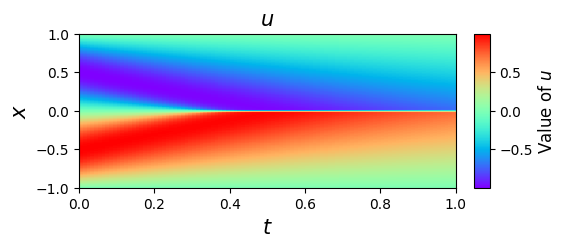

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

cmap = plt.get_cmap('jet')
heatmap1 = ax1.imshow(Exact_u,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[0, 1, -1, 1],
                      origin='lower',
                      aspect='auto')

ax1.set_title(r'$u$', fontsize=15)
ax1.set_xlabel(r'$t$', fontsize=15)
ax1.set_ylabel(r'$x$', fontsize=15)

# Add a color bar
cbar = fig.colorbar(heatmap1, ax=ax1, fraction=0.15, pad=0.04, aspect=10)
cbar.set_label(r'Value of $u$', fontsize=12)

plt.show()

In [7]:
random_seed = 1234
np.random.seed(random_seed)
number_observe_data = 100

index_t = (lhs(1, number_observe_data)) * len(t_exact)
index_t = np.floor(index_t).reshape(number_observe_data, ).astype(int)
observe_t = t_exact[index_t]

index_x = (lhs(1, number_observe_data)) * len(x_exact)
index_x = np.floor(index_x).reshape(number_observe_data, ).astype(int)
observe_x = x_exact[index_x]

observe_data = np.hstack((observe_x, observe_t))
observe_clear_u = Exact_u[index_x, index_t].reshape(-1, 1)

noise_nu = 0.0
noise_std = 0.1
noise_u = np.random.normal(loc=noise_nu, scale=noise_std, size=observe_clear_u.shape)
observe_u = observe_clear_u + noise_u

observe_data = numpy_to_tensor(observe_data,
                               var_name="observe_data",
                               value_range_dim=True,
                               to_torch=True,
                               to_cuda=True,
                               requires_grad=True)

observe_clear_u = numpy_to_tensor(observe_clear_u,
                                  var_name="observe_clear_u",
                                  value_range_dim=True,
                                  to_torch=True,
                                  to_cuda=True,
                                  requires_grad=True)

observe_u = numpy_to_tensor(observe_u,
                            var_name="observe_u",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

observe_data_x_inside = observe_data[:, 0:1]
observe_data_t_inside = observe_data[:, 1:2]

observe_data: Column 0: range from -0.9921568627450981 to 1.0
observe_data: Column 1: range from 0.0 to 0.99
observe_clear_u: Column 0: range from -0.99772670660646 to 0.9984270657408356
observe_u: Column 0: range from -1.1768691197549743 to 1.05044266436092


In [8]:
np.random.seed(5678)
n_test_data = 10000

index_t = (lhs(1, n_test_data)) * len(t_exact)
index_t = np.floor(index_t).reshape(n_test_data, ).astype(int)
test_data_t = t_exact[index_t]

index_x = (lhs(1, n_test_data)) * len(x_exact)
index_x = np.floor(index_x).reshape(n_test_data, ).astype(int)
test_data_x = x_exact[index_x]

test_data = np.hstack((test_data_x, test_data_t))
test_u = Exact_u[index_x, index_t].reshape(-1, 1)

test_data = numpy_to_tensor(test_data,
                            var_name="test_data",
                            value_range_dim=True,
                            to_torch=True,
                            to_cuda=True,
                            requires_grad=True)

test_u = numpy_to_tensor(test_u,
                         var_name="test_u",
                         value_range_dim=True,
                         to_torch=True,
                         to_cuda=True,
                         requires_grad=True)

test_data_x_inside = test_data[:, 0:1]
test_data_t_inside = test_data[:, 1:2]

test_data: Column 0: range from -1.0 to 1.0
test_data: Column 1: range from 0.0 to 0.99
test_u: Column 0: range from -0.9993678255737524 to 0.9999810273487268


In [9]:
print('The number of observational data J:', len(observe_u))

The number of observational data J: 100


In [10]:
def output_transform(data_input, u_input):
    
    x_in = data_input[:, 0:1]
    t_in = data_input[:, 1:2]

    return (1 - x_in) * (1 + x_in) * (1 - torch.exp(-t_in)) * u_input - torch.sin(np.pi * x_in)

In [11]:
def get_loss_f_1(x_grad, t_grad, PINNs, C, return_sequence='not'):

    ########### loss f  ###########
    E_inside = PINNs(torch.cat((x_grad, t_grad), dim=1))
    E_inside = output_transform(torch.cat((x_grad, t_grad), dim=1), E_inside)

    E_x = compute_higher_order_derivatives(E_inside, [x_grad])
    E_xx = compute_higher_order_derivatives(E_x, [x_grad])
    E_t = compute_higher_order_derivatives(E_inside, [t_grad])

    loss_term = E_t + E_inside * E_x - C * (E_xx)

    if return_sequence == 'yes':
        return torch.square(loss_term)
    else:
        return torch.mean(torch.square(loss_term))

In [12]:
x_inside_all = torch.cat((x_inside,observe_data[:,0:1]),dim=0)
t_inside_all = torch.cat((t_inside,observe_data[:,1:2]),dim=0)

In [13]:
data_inputs = {
    'x_inside_all': x_inside_all,
    't_inside_all': t_inside_all,
    'x_inside': x_inside,
    't_inside': t_inside,
    'observe_data': observe_data,
    'observe_u': observe_u,
    'observe_clear_u': observe_clear_u,
    'observe_data_x_inside': observe_data_x_inside,
    'observe_data_t_inside': observe_data_t_inside,
    'test_data': test_data,
    'test_u': test_u,
    'test_data_x_inside': test_data_x_inside,
    'test_data_t_inside': test_data_t_inside,
    'C1': None,
}

In [14]:
#Paper reproduction
random_seed_set = 1234
set_random_seed(random_seed_set)

In [15]:
net_settings_for_PINNs_1 = NetSetting(input_dims=2,
                                     hidden_neurons_list=[20] * 8,
                                     output_dims=1,
                                     hidden_activation='tanh',
                                     output_activation=None,
                                     initializer_method='xavier')

PINNs_1 = get_mlp_pinn(net_settings_for_PINNs_1)
PINNs_1.cuda()

initialize_weights(PINNs_1, net_settings_for_PINNs_1.initializer_method)

optimizer1 = optim.Adam(PINNs_1.parameters(),
                        lr=0.001,
                        betas=(0.9, 0.999),
                        eps=1e-08,
                        weight_decay=0,
                        amsgrad=False)

C1 = torch.tensor(0.5, requires_grad=True)
optimizer1.add_param_group({'params': [C1], 'lr': 0.001})

In [16]:
nIter1 = 10000
it = 0
training_recorder_1 = training_recorder()

while it < nIter1:

    #########loss f #########
    loss_f = get_loss_f_1(x_inside_all, t_inside_all, PINNs_1, C1)

    #########loss T noisy observation#########
    E_observation = PINNs_1(observe_data)
    E_observation = output_transform(observe_data, E_observation)
    loss_T_observation_noisy = torch.mean(torch.square(E_observation - observe_u))

    #########loss PI#########
    loss_all = loss_f + 10 * loss_T_observation_noisy

    optimizer1.zero_grad()
    loss_all.backward()
    optimizer1.step()

    data_inputs['C1'] = C1
    test_loss  = training_calculator(PINNs_1, get_loss_f_1,
                                     training_recorder_1, data_inputs, output_transform)
    
    if it % 1000 == 0:
        print(f"Iterations: {it}, train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}")
        print('Estimated parameter:',C1)
    
    it = it + 1
    
print(f"Final result: train_loss: {loss_all.item():.8f}, test_loss: {test_loss:.6f}")
print('Estimated parameter:',C1)

output_dir = '../experimental_data/Burgers/original_N1/'
training_recorder_1.save(output_dir)

Iterations: 0, train_loss: 15.14218140, test_loss: 0.590899
Estimated parameter: tensor(0.4990, requires_grad=True)
Iterations: 1000, train_loss: 0.23230022, test_loss: 0.135461
Estimated parameter: tensor(0.0182, requires_grad=True)
Iterations: 2000, train_loss: 0.12390422, test_loss: 0.058246
Estimated parameter: tensor(0.0050, requires_grad=True)
Iterations: 3000, train_loss: 0.11339245, test_loss: 0.045073
Estimated parameter: tensor(0.0041, requires_grad=True)
Iterations: 4000, train_loss: 0.11906631, test_loss: 0.045807
Estimated parameter: tensor(0.0038, requires_grad=True)
Iterations: 5000, train_loss: 0.10923770, test_loss: 0.043630
Estimated parameter: tensor(0.0036, requires_grad=True)
Iterations: 6000, train_loss: 0.10894788, test_loss: 0.042691
Estimated parameter: tensor(0.0035, requires_grad=True)
Iterations: 7000, train_loss: 0.11024303, test_loss: 0.044393
Estimated parameter: tensor(0.0034, requires_grad=True)
Iterations: 8000, train_loss: 0.10666779, test_loss: 0.042